In [9]:
import pyomo.environ as pe
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import stats

# HOW TO SETUP OPTIMIZER:

To run pyomo with the current `SingleMarketSolver` implementation you'll need `GLPK` package:

Download solver for pyomo from here: https://sourceforge.net/projects/winglpk/

Extract it to some folder and specify path to `./glpsol.exe` executable for pyomo solver. 

For defined SingleMarketSolver class - `pe.SolverFactory('glpk', executable=r"C:\glpk\w64\glpsol.exe")`

# 1. Implementing SingleMarketSolver

In [2]:

class SingleMarketSolver:

    def __init__(self, **kwargs):
        self.output = []
        self.model = None
        self.data = None
        self.kwargs = kwargs  

    def define(self, data, **kwargs):
        self.data = data
        self.kwargs.update(kwargs) 


        capacity_mwh = 2.0
        max_power_mw = 1.0
        timestep_hours = 0.25  # 15 min
        max_energy_per_step = max_power_mw * timestep_hours
        max_cycles_per_day = 2
        max_daily_throughput = capacity_mwh * max_cycles_per_day  # MWh/day

        model = pe.ConcreteModel()
        model.T = pe.RangeSet(0, len(data.index) - 1)

        up_act_col = self.kwargs.get("up_act_col", "LT_mfrr_SA_up_activ")
        down_act_col = self.kwargs.get("down_act_col", "LT_mfrr_SA_down_activ")
        up_price_col = self.kwargs.get("up_price_col", "LT_up_sa_cbmp")
        down_price_col = self.kwargs.get("down_price_col", "LT_down_sa_cbmp")

        model.ua = pe.Param(model.T, initialize={t: float(data[up_act_col].iloc[t]) for t in range(len(data))})
        model.da = pe.Param(model.T, initialize={t: float(data[down_act_col].iloc[t]) for t in range(len(data))})
        model.up_price = pe.Param(model.T, initialize={t: float(data[up_price_col].iloc[t]) for t in range(len(data))})
        model.down_price = pe.Param(model.T, initialize={t: float(data[down_price_col].iloc[t]) for t in range(len(data))})

        model.capacity = capacity_mwh
        model.max_step_energy = max_energy_per_step
        model.max_daily_throughput = max_daily_throughput

        model.charge = pe.Var(model.T, within=pe.Binary)
        model.discharge = pe.Var(model.T, within=pe.Binary)
        model.soc = pe.Var(model.T, bounds=(0, capacity_mwh))
        model.energy_charged = pe.Var(model.T, bounds=(0, max_energy_per_step))
        model.energy_discharged = pe.Var(model.T, bounds=(0, max_energy_per_step))

        # Constraints
        def charge_activation_rule(m, t):
            return m.energy_charged[t] <= min(m.max_step_energy, m.da[t]) * m.charge[t]
        model.charge_activation_con = pe.Constraint(model.T, rule=charge_activation_rule)

        def discharge_activation_rule(m, t):
            return m.energy_discharged[t] <= min(m.max_step_energy, m.ua[t]) * m.discharge[t]
        model.discharge_activation_con = pe.Constraint(model.T, rule=discharge_activation_rule)

        def no_simultaneous_action(m, t):
            return m.charge[t] + m.discharge[t] <= 1
        model.no_simul_con = pe.Constraint(model.T, rule=no_simultaneous_action)

        def soc_balance_rule(m, t):
            if t == 0:
                return pe.Constraint.Skip  
            else:
                return m.soc[t] == m.soc[t-1] + m.energy_charged[t] - m.energy_discharged[t]
        model.soc_balance_con = pe.Constraint(model.T, rule=soc_balance_rule)

        days = data.index.normalize().unique()
        model.daily_throughput_con = pe.ConstraintList()
        for day in days:
            idxs = [i for i, ts in enumerate(data.index) if ts.normalize() == day]
            model.daily_throughput_con.add(
                sum(model.energy_charged[t] + model.energy_discharged[t] for t in idxs) <= max_daily_throughput
            )

        def _maximise_profit(m):
            revenue = sum(m.energy_discharged[t] * m.up_price[t] for t in m.T)
            cost = sum(m.energy_charged[t] * m.down_price[t] for t in m.T)
            return revenue - cost
        model.obj = pe.Objective(rule=_maximise_profit, sense=pe.maximize)

        self.model = model
        return self

    def solve(self):
        if self.model is not None:
            solver = pe.SolverFactory('glpk', executable=r"C:\glpk\w64\glpsol.exe")
            solver.options['mipgap'] = 0.01
            results = solver.solve(self.model, tee=True)
            print(results.solver.status, results.solver.termination_condition)

            res = []
            for t in self.model.T:
                rec = {
                    'datetime': self.data.index[t],
                    'up_activation': pe.value(self.model.ua[t]),
                    'down_activation': pe.value(self.model.da[t]),
                    'charge_MWh': pe.value(self.model.energy_charged[t]),
                    'discharge_MWh': pe.value(self.model.energy_discharged[t]),
                    'soc_MWh': pe.value(self.model.soc[t]),
                }
                res.append(rec)
            self.output = pd.DataFrame(res)
        return self

# Implementing Method run_daily_optimizations_over_dataset

In [3]:
def run_daily_optimizations_over_dataset(df, solver_class, **solver_kwargs):
    df = df.sort_index()

    all_results = []
    previous_day_end_soc = 0.0

    days = df.index.normalize().unique()

    for day in days:
        day_data = df.loc[df.index.normalize() == day].copy()

        solver = solver_class(**solver_kwargs)
        solver.define(day_data)

        solver.model.soc[0].fix(previous_day_end_soc)

        solver.solve()

        daily_res = solver.output.copy()
        daily_res["day"] = day

        all_results.append(daily_res)

        previous_day_end_soc = daily_res["soc_MWh"].iloc[-1]

    full_results = pd.concat(all_results).reset_index(drop=True)

    total_revenue = 0.0
    total_cost = 0.0
    for day in days:
        day_data = df.loc[df.index.normalize() == day]
        day_res = full_results[full_results["day"] == day]
        up_prices = day_data[solver_kwargs.get("up_price_col", "LT_up_sa_cbmp")].values
        down_prices = day_data[solver_kwargs.get("down_price_col", "LT_down_sa_cbmp")].values
        discharge = day_res["discharge_MWh"].values
        charge = day_res["charge_MWh"].values

        total_revenue += (discharge * up_prices).sum()
        total_cost += (charge * down_prices).sum()

    total_profit = total_revenue - total_cost

    return full_results, total_profit

# EXAMPLE OF MODEL EXECUTION

In [4]:
df = pd.read_csv("data/market_data.csv", parse_dates=True, index_col=0)

df["LT_up_sa_cbmp"] = df["LT_up_sa_cbmp"].interpolate(method="linear", limit_direction="both")
df["LT_down_sa_cbmp"] = df["LT_down_sa_cbmp"].interpolate(method="linear", limit_direction="both")

df["LT_mfrr_SA_down_activ"] = df["LT_mfrr_SA_down_activ"].fillna(0)
df["LT_mfrr_SA_up_activ"] = df["LT_mfrr_SA_up_activ"].fillna(0)


full_results, total_profit = run_daily_optimizations_over_dataset(
    df,
    SingleMarketSolver,
    up_act_col="LT_mfrr_SA_up_activ",
    down_act_col="LT_mfrr_SA_down_activ",
    up_price_col="LT_up_sa_cbmp",
    down_price_col="LT_down_sa_cbmp"
)

print("Total profit EUR:", total_profit)
full_results.head()

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.01 --write C:\Users\lmluk\AppData\Local\Temp\tmpq4jmivdr.glpk.raw
 --wglp C:\Users\lmluk\AppData\Local\Temp\tmpornloleh.glpk.glp --cpxlp C:\Users\lmluk\AppData\Local\Temp\tmp4bqygh98.pyomo.lp
Reading problem data from 'C:\Users\lmluk\AppData\Local\Temp\tmp4bqygh98.pyomo.lp'...
C:\Users\lmluk\AppData\Local\Temp\tmp4bqygh98.pyomo.lp:2834: warning: lower bound of variable 'x195' redefined
C:\Users\lmluk\AppData\Local\Temp\tmp4bqygh98.pyomo.lp:2834: warning: upper bound of variable 'x195' redefined
384 rows, 479 columns, 1001 non-zeros
192 integer variables, all of which are binary
3026 lines were read
Writing problem data to 'C:\Users\lmluk\AppData\Local\Temp\tmpornloleh.glpk.glp'...
2635 lines were written
GLPK Integer Optimizer, v4.65
384 rows, 479 columns, 1001 non-zeros
192 integer variables, all of which are binary
Preprocessing...
238 rows, 332 columns, 563 non-zeros
192 integer variables, all 

,datetime,up_activation,down_activation,charge_MWh,discharge_MWh,soc_MWh,day
0,2025-03-01 00:00:00+00:00,0.0,0.25,0.0,0.0,0.0,2025-03-01 00:00:00+00:00
1,2025-03-01 00:15:00+00:00,0.0,0.25,0.0,0.0,0.0,2025-03-01 00:00:00+00:00
2,2025-03-01 00:30:00+00:00,0.0,0.25,0.0,0.0,0.0,2025-03-01 00:00:00+00:00
3,2025-03-01 00:45:00+00:00,0.0,0.25,0.0,0.0,0.0,2025-03-01 00:00:00+00:00
4,2025-03-01 01:00:00+00:00,0.0,0.25,0.0,0.0,0.0,2025-03-01 00:00:00+00:00


# 4. 95% CI for profit per MWh

In [19]:
up_price_col = "LT_up_sa_cbmp"
down_price_col = "LT_down_sa_cbmp"

full_results["datetime"] = pd.to_datetime(full_results["datetime"]).dt.tz_localize(None)
df.index = pd.to_datetime(df.index).tz_localize(None)

full_results = full_results.set_index("datetime")

full_results = full_results.join(df[[up_price_col, down_price_col]], how="left")

full_results = full_results.reset_index()

full_results["profit"] = (
    full_results["discharge_MWh"] * full_results[up_price_col] -
    full_results["charge_MWh"] * full_results[down_price_col]
)

full_results["energy"] = full_results["charge_MWh"] + full_results["discharge_MWh"]

df_nonzero = full_results[full_results["energy"] > 1e-6].copy()

df_nonzero["profit_per_MWh"] = df_nonzero["profit"] / df_nonzero["energy"]

mean_profit = df_nonzero["profit_per_MWh"].mean()
std_profit = df_nonzero["profit_per_MWh"].std()
n = len(df_nonzero)

z = 1.96
se = std_profit / np.sqrt(n)
ci_lower = mean_profit - z * se
ci_upper = mean_profit + z * se

print(f"Mean profit per MWh: {mean_profit:.2f} EUR/MWh")
print(f"95% confidence interval: [{ci_lower:.2f}, {ci_upper:.2f}] EUR/MWh")


Mean profit per MWh: 256.68 EUR/MWh
95% confidence interval: [238.53, 274.83] EUR/MWh


# RESULTS VISUALISATION

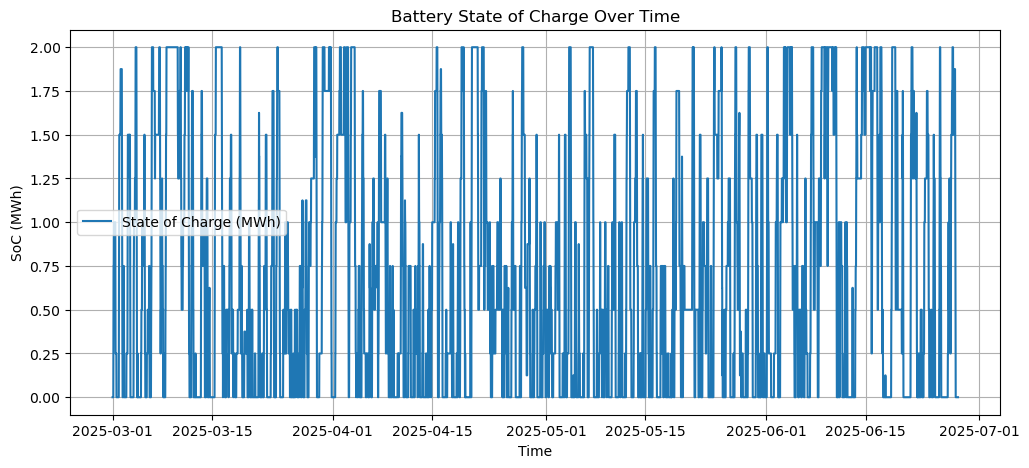

In [6]:


plt.figure(figsize=(12,5))
plt.plot(full_results['datetime'], full_results['soc_MWh'], label="State of Charge (MWh)")
plt.xlabel("Time")
plt.ylabel("SoC (MWh)")
plt.title("Battery State of Charge Over Time")
plt.grid(True)
plt.legend()
plt.show()

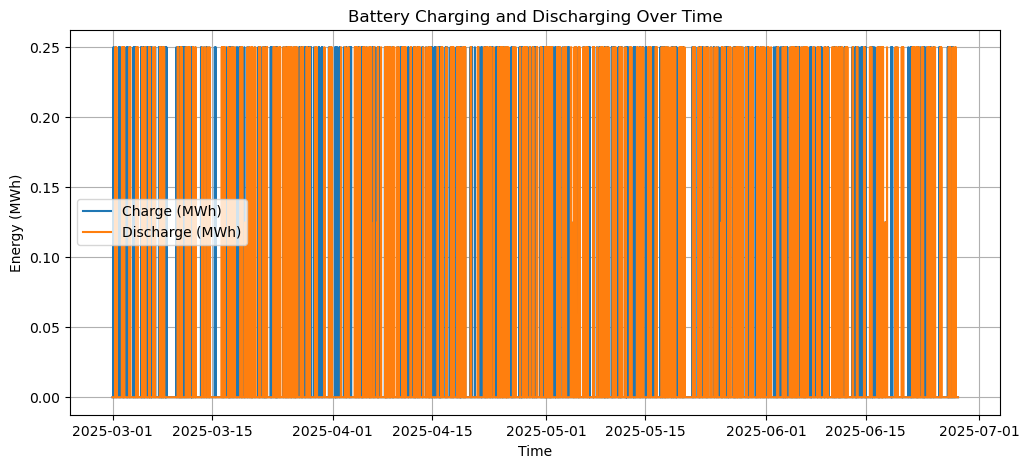

In [20]:
plt.figure(figsize=(12,5))
plt.plot(full_results['datetime'], full_results['charge_MWh'], label="Charge (MWh)")
plt.plot(full_results['datetime'], full_results['discharge_MWh'], label="Discharge (MWh)")
plt.xlabel("Time")
plt.ylabel("Energy (MWh)")
plt.title("Battery Charging and Discharging Over Time")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\lmluk\AppData\Local\Temp\ipykernel_13916\137280534.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["discharge_MWh"] * df["up_activation"]).sum() - (df["charge_MWh"] * df["down_activation"]).sum())


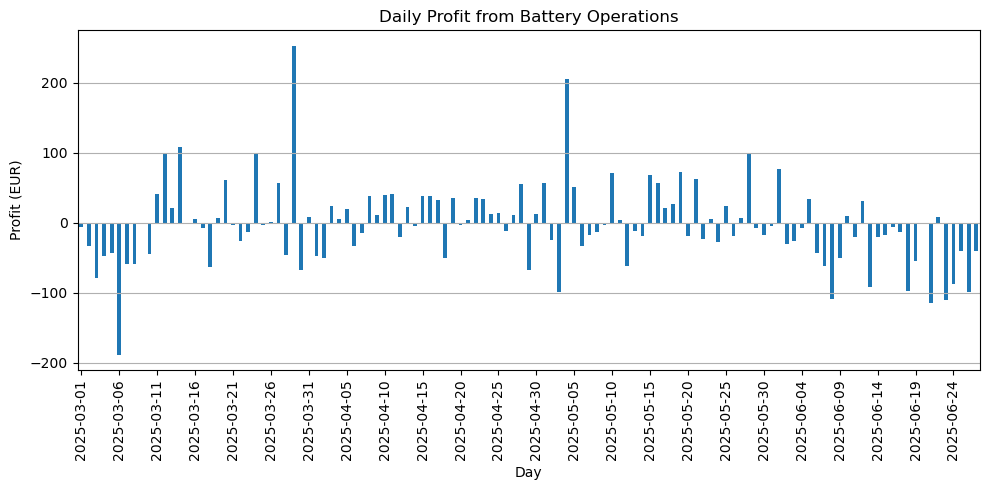

In [24]:
daily_profit = (
    full_results.groupby("day")
    .apply(lambda df: (df["discharge_MWh"] * df["up_activation"]).sum() - (df["charge_MWh"] * df["down_activation"]).sum())
)

plt.figure(figsize=(10, 5))
daily_profit.plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Profit (EUR)")
plt.title("Daily Profit from Battery Operations")
plt.grid(axis="y")

# Show only every 5th tick to avoid clutter
ticks_to_show = range(0, len(daily_profit), 5)
plt.xticks(ticks=ticks_to_show, labels=[daily_profit.index[i].strftime("%Y-%m-%d") for i in ticks_to_show], rotation=90)

plt.tight_layout()
plt.show()

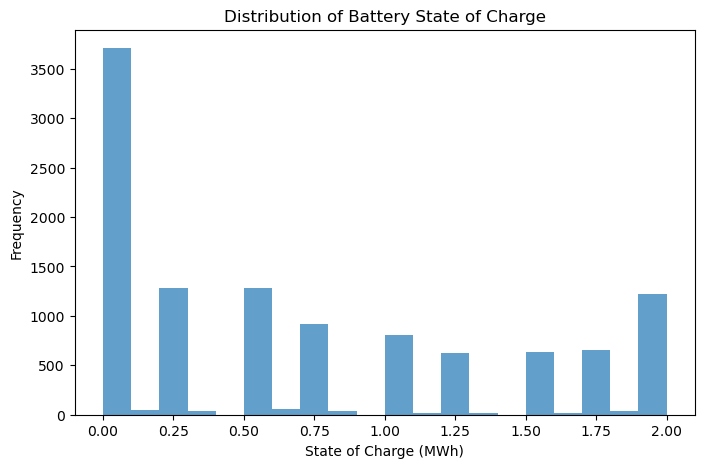

In [22]:
plt.figure(figsize=(8,5))
plt.hist(full_results['soc_MWh'], bins=20, alpha=0.7)
plt.xlabel("State of Charge (MWh)")
plt.ylabel("Frequency")
plt.title("Distribution of Battery State of Charge")
plt.show()

# 5. Depth of Cycle Calculations

Let's say we calculate the Depth of Cycle like this:

$$
\text{DoC} = \frac{|\text{SoC}_{\text{max}} - \text{SoC}_{\text{min}}|}{\text{Battery capacity (MWh)}}
$$

- SoC = State of Charge (MWh)  
- DoC is a fraction or percentage of full battery capacity cycled.

Then we need to detect cycles by SoC swings

- Find local maxima and minima in SoC time series  
- Each pair of consecutive extrema defines a cycle segment  
- Calculate DoC for each cycle as the normalized SoC difference  
